c:\Users\samto\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Training Loss: 0.6859221110671042, Validation Error: 0.5659574468085107
Epoch 26, Training Loss: 0.6828250921261529, Validation Error: 0.3872340425531915
Epoch 51, Training Loss: 0.6831983601861492, Validation Error: 0.3872340425531915
Epoch 76, Training Loss: 0.6831964786352834, Validation Error: 0.3872340425531915
Epoch 101, Training Loss: 0.6830703042858561, Validation Error: 0.3872340425531915
Epoch 126, Training Loss: 0.6828956150435322, Validation Error: 0.3872340425531915


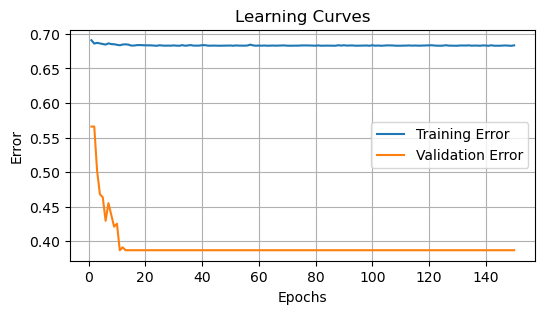

Training Accuracy: 0.5728429985855729
Test Accuracy: 0.5527426160337553


C:\Users\samto\AppData\Local\Temp\ipykernel_16732\2175581791.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
c:\Users\samto\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Training Loss: 0.6791833558274274, Validation Error: 0.4744897959183674
Epoch 26, Training Loss: 0.6778223996785417, Validation Error: 0.4744897959183674
Epoch 51, Training Loss: 0.6771309702240642, Validation Error: 0.4744897959183674
Epoch 76, Training Loss: 0.6758328521970528, Validation Error: 0.4744897959183674
Epoch 101, Training Loss: 0.6784448343605253, Validation Error: 0.4744897959183674
Epoch 126, Training Loss: 0.6763209793435868, Validation Error: 0.4744897959183674


C:\Users\samto\AppData\Local\Temp\ipykernel_16732\2175581791.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
c:\Users\samto\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Training Loss: 0.6879425057127506, Validation Error: 0.4285714285714286
Epoch 26, Training Loss: 0.6863850009592274, Validation Error: 0.4285714285714286
Epoch 51, Training Loss: 0.6865500527092173, Validation Error: 0.4285714285714286
Epoch 76, Training Loss: 0.6895478474188454, Validation Error: 0.4285714285714286
Epoch 101, Training Loss: 0.6863746810563003, Validation Error: 0.4285714285714286
Epoch 126, Training Loss: 0.6863010607188261, Validation Error: 0.4285714285714286


C:\Users\samto\AppData\Local\Temp\ipykernel_16732\2175581791.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
c:\Users\samto\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Training Loss: 0.6864719815716123, Validation Error: 0.4693877551020408
Epoch 26, Training Loss: 0.6859005356803158, Validation Error: 0.40306122448979587
Epoch 51, Training Loss: 0.6863216500596951, Validation Error: 0.40306122448979587
Epoch 76, Training Loss: 0.6856849261145099, Validation Error: 0.40306122448979587
Epoch 101, Training Loss: 0.6867466234111947, Validation Error: 0.40306122448979587
Epoch 126, Training Loss: 0.6861122239463019, Validation Error: 0.40306122448979587


C:\Users\samto\AppData\Local\Temp\ipykernel_16732\2175581791.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
c:\Users\samto\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Training Loss: 0.6839137224639084, Validation Error: 0.4642857142857143
Epoch 26, Training Loss: 0.6831079900946369, Validation Error: 0.3877551020408163
Epoch 51, Training Loss: 0.6831881247905794, Validation Error: 0.3877551020408163
Epoch 76, Training Loss: 0.6831664081752831, Validation Error: 0.3877551020408163
Epoch 101, Training Loss: 0.6832466340580011, Validation Error: 0.3877551020408163
Epoch 126, Training Loss: 0.683171459271311, Validation Error: 0.3877551020408163


C:\Users\samto\AppData\Local\Temp\ipykernel_16732\2175581791.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
c:\Users\samto\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Training Loss: 0.6840542417516058, Validation Error: 0.4387755102040817
Epoch 26, Training Loss: 0.6808896812393367, Validation Error: 0.4387755102040817
Epoch 51, Training Loss: 0.6810526322736381, Validation Error: 0.4387755102040817
Epoch 76, Training Loss: 0.6807946360850989, Validation Error: 0.4387755102040817
Epoch 101, Training Loss: 0.6828198196140941, Validation Error: 0.4387755102040817
Epoch 126, Training Loss: 0.6807647464476669, Validation Error: 0.4387755102040817
Cross-Validation Accuracies: [0.5255102040816326, 0.5714285714285714, 0.5969387755102041, 0.6122448979591837, 0.5612244897959183]
Average Cross-Validation Accuracy: 0.5734693877551019


In [104]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd
import tkinter as tk
from tkinter import filedialog
import pandas_ta as ta
from sklearn.model_selection import TimeSeriesSplit
from torch.nn.utils.rnn import pad_sequence

# Initialize the Tkinter root window
root = tk.Tk()
root.wm_attributes('-topmost', 1)
root.withdraw()

# Normalize data and assign movement direction values
def prep(dataset):
    scaler = StandardScaler()

    dataset['RSI (14D)'] = ta.rsi(dataset['Close'], length=14)
    dataset['20 Day CCI'] = ta.cci(high=dataset['High'], low=dataset['Low'], 
                                   close=dataset['Close'], length=20)
    dataset['Williams %R'] = ta.willr(high=dataset['High'], low=dataset['Low'], 
                                      close=dataset['Close'], length=14)
    dataset['EMA (5D)'] = dataset['Close'].ewm(span=5, adjust=False).mean()

    bollinger = ta.bbands(dataset['Close'], length=20, std=2)
    dataset['BB_upper'] = bollinger['BBU_20_2.0']
    dataset['BB_middle'] = bollinger['BBM_20_2.0']
    dataset['BB_lower'] = bollinger['BBL_20_2.0']

    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI (14D)', 
                '20 Day CCI', 'Williams %R']
    
    dataset[features] = dataset[features].astype(float)
    dataset[features] = scaler.fit_transform(dataset[features])

    dataset['MA10'] = dataset['Close'].rolling(window=10).mean()
    dataset['MA50'] = dataset['Close'].rolling(window=50).mean()
    
    dataset['Target'] = np.where(dataset['Close'].shift(-1) > dataset['Close'], 1, 0)
    prepared_data = dataset.dropna()
    return prepared_data, scaler

# Define LSTM Model class
class LSTM_Model(nn.Module):
    def __init__(self, input_layer, hidden_layer, output_layer, dropout_rate=0.2):
        super(LSTM_Model, self).__init__()
        self.hidden_layer = hidden_layer
        self.dropout_rate = dropout_rate
        self.lstm = nn.LSTM(input_layer, hidden_layer, batch_first=True, dropout=dropout_rate, bidirectional=False)
        self.linear_layer = nn.Linear(hidden_layer, output_layer)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer).cuda(),
                            torch.zeros(1,1,self.hidden_layer).cuda())

    def forward(self, input_tensor):
        self.hidden_cell = (torch.zeros(1, input_tensor.size(0), self.hidden_layer).cuda(), 
                            torch.zeros(1, input_tensor.size(0), self.hidden_layer).cuda())
        out, self.hidden_cell = self.lstm(input_tensor, self.hidden_cell)
        lstm_out_last = out[:, -1, :]
        predicted_values = self.linear_layer(lstm_out_last)
        return predicted_values

# Create sequences for input data and corresponding labels
def create_sequence(input_data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(input_data) - sequence_length):
        sequence = input_data[i : i + sequence_length, :-1]
        label = input_data[i + sequence_length, -1]
        sequences.append(sequence)
        labels.append(label)

    sequences = np.array(sequences)
    labels = np.array(labels)

    return sequences, labels

# Convert sequences and labels to PyTorch tensors
def convert_to_tensor(sequences, labels):
    # Convert sequences and labels to tensors
    sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
    labels = torch.tensor(labels, dtype=torch.float32).view(-1, 1)
    
    # Pad sequences
    sequences = pad_sequence(sequences, batch_first=True)
    
    return sequences, labels

# Train the model with data provided
def trainer(model, train_data, val_data, loss_func, opt, epochs, device='cuda'):
    train_errors, val_errors = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for sequence, labels in train_data:
            opt.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer).to(device),
                                 torch.zeros(1, 1, model.hidden_layer).to(device))
            
            sequence = sequence.to(device)
            labels = labels.to(device)

            y = model(sequence)
            loss = loss_func(y, labels)
            loss.backward()
            opt.step()

            epoch_loss += loss.item()

        # Compute average loss for the epoch
        train_errors.append(epoch_loss / len(train_data))

        # Validate the model
        val_accuracy = evaluate_model(model, val_data, device)
        val_errors.append(1 - val_accuracy)  # Convert accuracy to error

        # Print progress
        if epoch % 25 == 1:
            print(f'Epoch {epoch}, Training Loss: {epoch_loss / len(train_data)}, Validation Error: {1 - val_accuracy}')
    
    return train_errors, val_errors

def evaluate_model(model, data_loader, device='cuda'):
    model.eval()
    predictions, labels = [], []
    with torch.no_grad():
        for sequence, label in data_loader:
            sequence = sequence.float().to(device)
            output = model(sequence)
            pred = torch.round(torch.sigmoid(output)).cpu().numpy()
            predictions.extend(pred.flatten())
            labels.extend(label.numpy())
    return accuracy_score(labels, predictions)

# Time Series Cross-Validation
def time_series_cv(model_class, sequences, labels, n_splits, epochs, device='cuda'):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    accuracies = []

    for train_index, test_index in tscv.split(sequences):
        train_sequences, test_sequences = [sequences[i] for i in train_index], [sequences[i] for i in test_index]
        train_labels, test_labels = [labels[i] for i in train_index], [labels[i] for i in test_index]
        
        # Convert to tensors
        train_sequences, train_labels = convert_to_tensor(train_sequences, train_labels)
        test_sequences, test_labels = convert_to_tensor(test_sequences, test_labels)

        # Create dataLoaders
        train_data = torch.utils.data.DataLoader(list(zip(train_sequences, train_labels)), shuffle=True, batch_size=1)
        test_data = torch.utils.data.DataLoader(list(zip(test_sequences, test_labels)), shuffle=False, batch_size=1)
        
        # Initialize model
        model = model_class(input_layer=10, hidden_layer=150, output_layer=1, dropout_rate=0.2).to(device)
        opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
        loss_func = nn.BCEWithLogitsLoss()

        # Train and evaluate
        train_errors, val_errors = trainer(model, train_data, test_data, loss_func, opt, epochs, device)
        test_accuracy = evaluate_model(model, test_data, device)
        accuracies.append(test_accuracy)
    
    return accuracies

# Load and prepare data
file_path = filedialog.askopenfilename(parent=root, title="Select A File")
ticker = pd.read_csv(file_path)
ticker, scaler = prep(ticker)

# Create sequences
sequence_length = 10
sequences, labels = create_sequence(ticker[['Open', 'High', 'Low', 'Close', 'Volume', 
                                            'RSI (14D)', '20 Day CCI', 'Williams %R',
                                              'MA10', 'MA50', 'Target']].values, sequence_length)

# Convert sequences and labels to tensors
sequences, labels = convert_to_tensor(sequences, labels)

# Split into training, validation, and test sets
train_size = int(len(sequences) * 0.6)
val_size = int(len(sequences) * 0.2)
train_sequences = sequences[:train_size]
val_sequences = sequences[train_size:train_size + val_size]
test_sequences = sequences[train_size + val_size:]

train_data = torch.utils.data.DataLoader(list(zip(train_sequences, labels[:train_size])), shuffle=True, batch_size=1)
val_data = torch.utils.data.DataLoader(list(zip(val_sequences, labels[train_size:train_size + val_size])), shuffle=False, batch_size=1)
test_data = torch.utils.data.DataLoader(list(zip(test_sequences, labels[train_size + val_size:])), shuffle=False, batch_size=1)

# Initialize model
model = LSTM_Model(input_layer=10, hidden_layer=50, output_layer=1, dropout_rate=0.2).to('cuda')
loss_func = nn.BCEWithLogitsLoss()
opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

# Train
epochs = 150
train_errors, val_errors = trainer(model, train_data, val_data, loss_func, opt, epochs, device='cuda')

plt.figure(figsize=(6, 3))
plt.plot(range(1, epochs + 1), train_errors, label='Training Error')
plt.plot(range(1, epochs + 1), val_errors, label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.show()

train_accuracy = evaluate_model(model, train_data)
print(f'Training Accuracy: {train_accuracy}')

test_accuracy = evaluate_model(model, test_data)
print(f'Test Accuracy: {test_accuracy}')

# Perform Time Series Cross-Validation
n_splits = 5
accuracies = time_series_cv(LSTM_Model, sequences, labels, n_splits, epochs, device='cuda')
print(f'Cross-Validation Accuracies: {accuracies}')
print(f'Average Cross-Validation Accuracy: {np.mean(accuracies)}')



In [77]:
import copy

baseline_predictions = predictor(model, test_data)
baseline_accuracy = accuracy_score(test_labels, baseline_predictions)
print(f'Baseline Accuracy: {baseline_accuracy}')


def permutation_importance(model, test_data, test_labels, sequence_length, features, scaler):
    baseline_predictions = predictor(model, test_data)
    baseline_accuracy = accuracy_score(test_labels, baseline_predictions)
    feature_importances = {}
    
    for feature_idx, feature in enumerate(features):
        shuffled_test_data = copy.deepcopy(ticker)
        
        # Shuffle the specific feature column
        shuffled_test_data[feature] = np.random.permutation(shuffled_test_data[feature].values)
        
        # Create sequences for shuffled data
        shuffled_sequences = create_sequence(shuffled_test_data[features + ['Target']].values, sequence_length)
        
        # Split shuffled data into test sequences
        shuffled_test_data = torch.utils.data.DataLoader(shuffled_sequences[train_size:], shuffle=False, batch_size=1)
        
        # Get predictions with shuffled data
        shuffled_predictions = predictor(model, shuffled_test_data)
        
        # Calculate the accuracy with shuffled data
        shuffled_accuracy = accuracy_score(test_labels, shuffled_predictions)
        
        # Calculate importance as the drop in accuracy
        feature_importance = baseline_accuracy - shuffled_accuracy
        feature_importances[feature] = feature_importance
        print(f'Feature: {feature}, Importance: {feature_importance}')
    
    return feature_importances

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI (14D)', 
              '20 Day CCI', 'Williams %R']

feature_importances = permutation_importance(model, test_data, test_labels, sequence_length, features, scaler)

# Sort and print the feature importances
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances (sorted):")
for feature, importance in sorted_importances:
    print(f'{feature}: {importance}')

C:\Users\samto\AppData\Local\Temp\ipykernel_16732\3158429686.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(sequence).float().cuda()


Baseline Accuracy: 0.5020661157024794


C:\Users\samto\AppData\Local\Temp\ipykernel_16732\3158429686.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(sequence).float().cuda()
C:\Users\samto\AppData\Local\Temp\ipykernel_16732\3158429686.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(sequence).float().cuda()


Feature: Open, Importance: 0.01446280991735538


C:\Users\samto\AppData\Local\Temp\ipykernel_16732\3158429686.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(sequence).float().cuda()


Feature: High, Importance: 0.0020661157024792765


C:\Users\samto\AppData\Local\Temp\ipykernel_16732\3158429686.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(sequence).float().cuda()


Feature: Low, Importance: 0.02066115702479332


C:\Users\samto\AppData\Local\Temp\ipykernel_16732\3158429686.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(sequence).float().cuda()


Feature: Close, Importance: 0.018595041322314043


C:\Users\samto\AppData\Local\Temp\ipykernel_16732\3158429686.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(sequence).float().cuda()


Feature: Volume, Importance: -0.018595041322314043


C:\Users\samto\AppData\Local\Temp\ipykernel_16732\3158429686.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(sequence).float().cuda()


Feature: RSI (14D), Importance: -0.01446280991735538


C:\Users\samto\AppData\Local\Temp\ipykernel_16732\3158429686.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(sequence).float().cuda()


Feature: 20 Day CCI, Importance: 0.0


C:\Users\samto\AppData\Local\Temp\ipykernel_16732\3158429686.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(sequence).float().cuda()


Feature: Williams %R, Importance: -0.008264462809917328
Feature Importances (sorted):
Low: 0.02066115702479332
Close: 0.018595041322314043
Open: 0.01446280991735538
High: 0.0020661157024792765
20 Day CCI: 0.0
Williams %R: -0.008264462809917328
RSI (14D): -0.01446280991735538
Volume: -0.018595041322314043
